# Mining Big Data - Assignment 3: Task C - Basic Integration
# ===================================================

This notebook demonstrates the basic integration of pattern mining (Task A) and collaborative filtering (Task B) to create an enhanced recommendation system.

## 1. Introduction

In this notebook, we will:
1. Load and preprocess the dataset
2. Initialize our integrated system
3. Mine patterns using the FP-Growth algorithm
4. Set up collaborative filtering components
5. Generate and compare recommendations using different approaches:
   - Collaborative filtering only
   - Pattern mining only
   - Hybrid (integrated) approach
6. Evaluate the performance of each approach
7. Visualize the results

## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
import random
from collections import defaultdict

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# Create directories for outputs
os.makedirs('visualizations', exist_ok=True)
os.makedirs('results', exist_ok=True)

## 3. Set Up Path and Import Custom Modules

In [2]:
# Add parent directory to system path
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

# Check the project root path
print(f"Project root path: {project_root}")

# Import our integrated system module
try:
    from src.task_c.integration import IntegratedSystem
    print("Successfully imported IntegratedSystem module.")
except ModuleNotFoundError as e:
    print(f"Error importing IntegratedSystem: {e}")
    print(f"Please ensure the 'src' directory is correctly added to sys.path and contains 'task_c/integration.py'.")
    # Set a flag to indicate the module is not available
    integrated_system_available = False
else:
    integrated_system_available = True

Project root path: /home/shubharthak/Desktop/mbd-assingment3
Successfully imported IntegratedSystem module.


## 4. Load Dataset

In [3]:
print("Loading datasets...")
train_path = os.path.join(project_root, 'dataset', 'train.csv')
test_path = os.path.join(project_root, 'dataset', 'test.csv')

try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    print(f"Successfully loaded training data: {train_data.shape[0]} records from {train_path}")
    print(f"Successfully loaded test data: {test_data.shape[0]} records from {test_path}")
    
    # Display sample data
    print("\nSample data:")
    display(train_data.head())
    
    # Display data types
    print("\nData types:")
    display(train_data.dtypes)
    
    # Display basic statistics
    print("\nBasic statistics:")
    display(train_data.describe(include='all'))
    
except FileNotFoundError:
    print(f"Error: Dataset files not found at {train_path} or {test_path}")
    # Create dummy data for demonstration purposes
    print("Creating dummy data for demonstration...")
    
    # Create dummy train data
    train_data = pd.DataFrame({
        'User_id': [1001, 1001, 1002, 1003, 1002, 1004, 1001, 1005, 1006],
        'Date': pd.date_range(start='2021-01-01', periods=9, freq='D'),
        'itemDescription': ['milk', 'bread', 'eggs', 'milk', 'cheese', 'yogurt', 'apples', 'bread', 'milk']
    })
    
    # Create dummy test data
    test_data = pd.DataFrame({
        'User_id': [1001, 1002, 1003, 1004],
        'Date': pd.date_range(start='2021-02-01', periods=4, freq='D'),
        'itemDescription': ['cheese', 'milk', 'bread', 'eggs']
    })
    
    print("Dummy data created.")
    display(train_data.head())

Loading datasets...
Successfully loaded training data: 26985 records from /home/shubharthak/Desktop/mbd-assingment3/dataset/train.csv
Successfully loaded test data: 19383 records from /home/shubharthak/Desktop/mbd-assingment3/dataset/test.csv

Sample data:


,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351.0,1/01/2014,cleaner,2014.0,1.0,1.0,2.0
1,2226.0,1/01/2014,sausage,2014.0,1.0,1.0,2.0
2,1922.0,1/01/2014,tropical fruit,2014.0,1.0,1.0,2.0
3,2943.0,1/01/2014,whole milk,2014.0,1.0,1.0,2.0
4,1249.0,1/01/2014,citrus fruit,2014.0,1.0,1.0,2.0



Data types:


User_id            float64
Date                object
itemDescription     object
year               float64
month              float64
day                float64
day_of_week        float64
dtype: object


Basic statistics:


,User_id,Date,itemDescription,year,month,day,day_of_week
count,19382.000000,19382,19382,19382.000000,19382.000000,19382.000000,19382.000000
unique,NaN,384,167,NaN,NaN,NaN,NaN
top,NaN,28/08/2014,whole milk,NaN,NaN,NaN,NaN
freq,NaN,88,1135,NaN,NaN,NaN,NaN
mean,3009.050769,NaN,NaN,2014.057012,6.166134,15.391342,3.023785
std,1158.135945,NaN,NaN,0.231871,3.572992,8.750628,1.994446
min,1000.000000,NaN,NaN,2014.000000,1.000000,1.000000,0.000000
25%,1998.000000,NaN,NaN,2014.000000,3.000000,8.000000,1.000000
50%,3015.500000,NaN,NaN,2014.000000,6.000000,15.000000,3.000000
75%,4025.000000,NaN,NaN,2014.000000,9.000000,23.000000,5.000000


## 5. Initialize Integrated System

In [4]:
if integrated_system_available:
    print("\nInitializing integrated system...")
    try:
        system = IntegratedSystem(train_data, test_data)
        print("Integrated system successfully initialized.")
    except Exception as e:
        print(f"Error initializing IntegratedSystem: {e}")
        # Create a fallback message
        print("Proceeding with fallback approach...")
        system = None
else:
    print("IntegratedSystem module not available. Skipping system initialization.")


Initializing integrated system...
Found 53221 missing values in the dataset
Removing 7603 records with missing item descriptions
Found 53221 missing values in the dataset
Removing 7603 records with missing item descriptions
Found 53221 missing values in the dataset
Removing 7603 records with missing item descriptions
Integrated system successfully initialized.


## 6. Run Pattern Mining Component


Running pattern mining...
Running pattern mining with fpgrowth algorithm...
Preparing data for pattern mining...
Preprocessing: Removed NaN values from transactions
Prepared 8361 transactions
Encoded 8361 transactions with 167 unique items.
Running FPGROWTH algorithm with min_support=0.001...
148 itemset(s) from tree conditioned on items ()
7 itemset(s) from tree conditioned on items (shopping bags)
0 itemset(s) from tree conditioned on items (shopping bags, yogurt)
0 itemset(s) from tree conditioned on items (shopping bags, soda)
0 itemset(s) from tree conditioned on items (shopping bags, other vegetables)
0 itemset(s) from tree conditioned on items (shopping bags, whole milk)
0 itemset(s) from tree conditioned on items (shopping bags, rolls/buns)
0 itemset(s) from tree conditioned on items (shopping bags, root vegetables)
0 itemset(s) from tree conditioned on items (shopping bags, bottled water)
0 itemset(s) from tree conditioned on items (cleaner)
5 itemset(s) from tree conditioned

,support,itemsets
0,0.052745,(shopping bags)
1,0.002272,(cleaner)
2,0.060758,(bottled water)
3,0.025715,(sausage)
4,0.106686,(other vegetables)
5,0.048798,(tropical fruit)
6,0.130487,(whole milk)
7,0.005621,(flower (seeds))
8,0.034565,(citrus fruit)
9,0.030618,(coffee)


Total number of frequent itemsets found: 462

Columns in frequent_itemsets:
Index(['support', 'itemsets'], dtype='object')

Frequent itemset sizes:
length
1    148
2    314
Name: count, dtype: int64


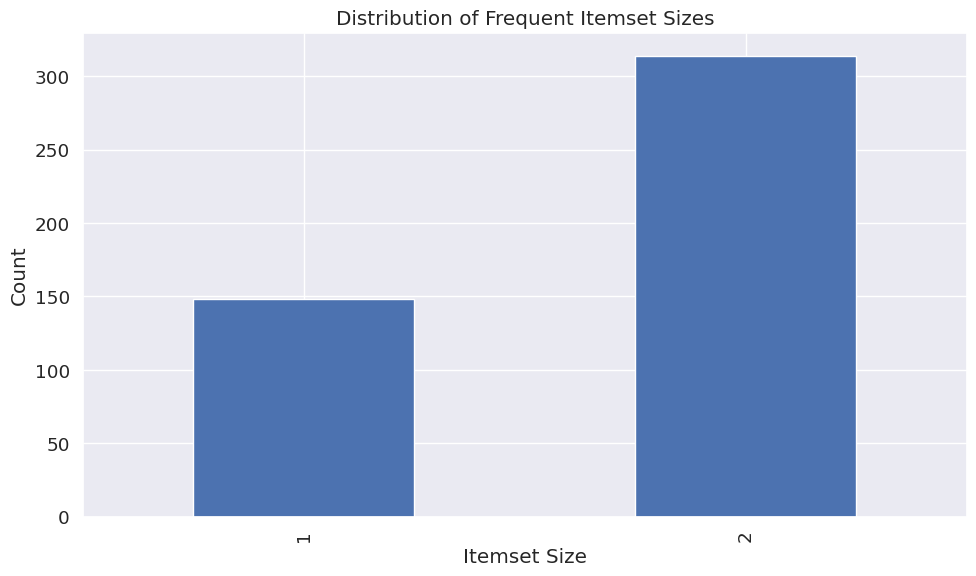

In [5]:
if system:
    print("\nRunning pattern mining...")
    start_time = time.time()
    
    # Use a slightly higher min_support for demonstration purposes (0.003 = 0.3%)
    system.mine_patterns(min_support=0.001, algorithm='fpgrowth')
    
    pattern_mining_time = time.time() - start_time
    print(f"Pattern mining completed in {pattern_mining_time:.2f} seconds")
    
    # Display frequent itemsets if available
    if hasattr(system.pattern_miner, 'frequent_itemsets') and system.pattern_miner.frequent_itemsets is not None:
        print("\nSample of frequent itemsets:")
        display(system.pattern_miner.frequent_itemsets.head(10))
    
    print(f"Total number of frequent itemsets found: {len(system.pattern_miner.frequent_itemsets)}")
    
    # Print column names to check what's available
    print("\nColumns in frequent_itemsets:")
    print(system.pattern_miner.frequent_itemsets.columns)
    
    # Create 'length' column if it doesn't exist
    if 'length' not in system.pattern_miner.frequent_itemsets.columns:
        # Assuming 'itemsets' contains lists/tuples of items
        if 'itemsets' in system.pattern_miner.frequent_itemsets.columns:
            system.pattern_miner.frequent_itemsets['length'] = system.pattern_miner.frequent_itemsets['itemsets'].apply(len)
        else:
            # If there's no itemsets column, we can't determine length
            print("No 'itemsets' column found to calculate length.")
            # Create a dummy plot instead
            plt.figure(figsize=(10, 6))
            plt.title('No itemset length data available')
            plt.savefig('visualizations/frequent_itemset_sizes.png')
            plt.show()
            # Skip the rest of the code
            raise ValueError("Cannot process frequent itemsets without proper structure")
    
    # Continue with the original code
    itemset_sizes = system.pattern_miner.frequent_itemsets['length'].value_counts().sort_index()
    print("\nFrequent itemset sizes:")
    print(itemset_sizes)
    
    # Visualize itemset sizes
    plt.figure(figsize=(10, 6))
    itemset_sizes.plot(kind='bar')
    plt.title('Distribution of Frequent Itemset Sizes')
    plt.xlabel('Itemset Size')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('visualizations/frequent_itemset_sizes.png')
    plt.show()
else:
    print("No frequent itemsets available for display.")

## 7. Prepare Collaborative Filtering Component

In [6]:
if system:
    print("\nPreparing collaborative filtering...")
    start_time = time.time()
    
    system.prepare_collaborative_filtering()
    
    cf_preparation_time = time.time() - start_time
    print(f"Collaborative filtering preparation completed in {cf_preparation_time:.2f} seconds")
    
    # Display user-item matrix if available
    if hasattr(system.collaborative_filter, 'user_item_matrix') and system.collaborative_filter.user_item_matrix is not None:
        print("\nSample of user-item matrix:")
        display(system.collaborative_filter.user_item_matrix.iloc[:5, :5])
        
        # Display matrix dimensions
        rows, cols = system.collaborative_filter.user_item_matrix.shape
        print(f"User-item matrix dimensions: {rows} users × {cols} items")
        
        # Display sparsity
        non_zero = system.collaborative_filter.user_item_matrix.astype(bool).sum().sum()
        total = rows * cols
        sparsity = 100 * (1 - non_zero / total)
        print(f"Matrix sparsity: {sparsity:.2f}%")
    else:
        print("User-item matrix not available for display.")


Preparing collaborative filtering...
Preparing collaborative filtering...
Preparing data for collaborative filtering...
Created user-item matrix of shape: (3493, 167)
Number of users: 3493
Number of items: 167
Computing user similarity matrix...
Similarity computation completed in 0.09 seconds
Computing item similarity matrix...
Similarity computation completed in 0.01 seconds
Training SVD model with 50 components...
Explained variance: 0.7917
SVD training completed in 1.57 seconds
Collaborative filtering preparation completed.
Collaborative filtering preparation completed in 1.69 seconds

Sample of user-item matrix:


itemDescription,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder
User_id,,,,,
1000.0,0.0,0.0,0.0,0.0,0.0
1001.0,0.0,0.0,0.0,0.0,0.0
1002.0,0.0,0.0,0.0,0.0,0.0
1003.0,0.0,0.0,0.0,0.0,0.0
1004.0,0.0,0.0,0.0,0.0,0.0


User-item matrix dimensions: 3493 users × 167 items
Matrix sparsity: 96.86%


## 8. Generate Recommendations - Comparison of Approaches

In [7]:
if system:
    # Select a random user for demonstration
    user_ids = train_data['User_id'].unique()
    selected_user_id = np.random.choice(user_ids)
    
    print(f"\nGenerating recommendations for user {selected_user_id}...")
    
    # 1. Hybrid (integrated) approach
    print("\n8.1 Hybrid approach (Pattern mining + Collaborative filtering):")
    start_time = time.time()
    hybrid_recommendations = system.generate_recommendations(
        user_id=selected_user_id,
        n_recommendations=10,
        with_patterns=True
    )
    hybrid_time = time.time() - start_time
    print(f"Hybrid recommendations generated in {hybrid_time:.4f} seconds")
    
    # 2. Collaborative filtering only
    print("\n8.2 Collaborative filtering only:")
    start_time = time.time()
    cf_recommendations = system.generate_recommendations(
        user_id=selected_user_id,
        n_recommendations=10,
        with_patterns=False
    )
    cf_time = time.time() - start_time
    print(f"CF-only recommendations generated in {cf_time:.4f} seconds")
    
    # Display the recommendations in a nicer format
    print("\n--- Comparison of recommendation approaches ---")
    print(f"User ID: {selected_user_id}")
    
    # Create a comparison dataframe
    hybrid_items = list(hybrid_recommendations.keys())[:10]
    hybrid_scores = list(hybrid_recommendations.values())[:10]
    
    cf_items = list(cf_recommendations.keys())[:10]
    cf_scores = list(cf_recommendations.values())[:10]
    
    # Create dataframes for each approach
    hybrid_df = pd.DataFrame({
        'Item': hybrid_items,
        'Score': hybrid_scores
    }).reset_index().rename(columns={'index': 'Rank'})
    hybrid_df['Rank'] = hybrid_df['Rank'] + 1
    
    cf_df = pd.DataFrame({
        'Item': cf_items,
        'Score': cf_scores
    }).reset_index().rename(columns={'index': 'Rank'})
    cf_df['Rank'] = cf_df['Rank'] + 1
    
    # Display side by side
    print("\nHybrid Recommendations:")
    display(hybrid_df)
    
    print("\nCollaborative Filtering Recommendations:")
    display(cf_df)
    
    # Check overlap
    common_items = set(hybrid_items).intersection(set(cf_items))
    print(f"\nOverlap: {len(common_items)} items in common between the two approaches")
    if common_items:
        print("Common items: " + ", ".join(common_items))


Generating recommendations for user 4181.0...

8.1 Hybrid approach (Pattern mining + Collaborative filtering):
User 4181.0 has purchased 3 unique items

Generating collaborative filtering recommendations...
User 4181.0 has purchased 3 unique items
Generated 20 recommendations in 0.00 seconds

Top recommendations:
1. oil (Score: 0.1860)
2. hygiene articles (Score: 0.1468)
3. butter milk (Score: 0.1418)
4. chewing gum (Score: 0.0837)
5. beef (Score: 0.0504)
6. berries (Score: 0.0448)
7. grapes (Score: 0.0389)
8. butter (Score: 0.0363)
9. pot plants (Score: 0.0361)
10. sausage (Score: 0.0360)
11. candy (Score: 0.0331)
12. pip fruit (Score: 0.0324)
13. seasonal products (Score: 0.0324)
14. whipped/sour cream (Score: 0.0297)
15. salty snack (Score: 0.0266)
16. canned beer (Score: 0.0251)
17. pastry (Score: 0.0245)
18. long life bakery product (Score: 0.0238)
19. pasta (Score: 0.0234)
20. fruit/vegetable juice (Score: 0.0230)

Generating pattern-based recommendations...

Top pattern-based r

,Rank,Item,Score
0,1,oil,0.500000
1,2,whole milk,0.500000
2,3,hygiene articles,0.394466
3,4,butter milk,0.381076
4,5,pip fruit,0.374875
5,6,other vegetables,0.353659
6,7,fruit/vegetable juice,0.326237
7,8,yogurt,0.292683
8,9,soda,0.268293
9,10,whipped/sour cream,0.246460



Collaborative Filtering Recommendations:


,Rank,Item,Score
0,1,oil,0.186031
1,2,hygiene articles,0.146766
2,3,butter milk,0.141784
3,4,chewing gum,0.083708
4,5,beef,0.050354
5,6,berries,0.044756
6,7,grapes,0.038879
7,8,butter,0.036290
8,9,pot plants,0.036100
9,10,sausage,0.035959



Overlap: 3 items in common between the two approaches
Common items: butter milk, oil, hygiene articles


## 9. Evaluate Recommendation Methods

In [8]:
if system:
    print("\nEvaluating recommendation methods...")
    
    # Set number of users for evaluation (use a small number for demonstration)
    n_users_eval = 10
    print(f"Using {n_users_eval} users for evaluation")
    
    # 1. Evaluate hybrid recommendations
    print("\n9.1 Evaluating hybrid recommendations:")
    try:
        hybrid_metrics = system.evaluate_recommendations(method='hybrid', n_users=n_users_eval)
        print(f"Hit Rate: {hybrid_metrics['hit_rate']:.4f}")
        print(f"Average Precision: {hybrid_metrics['average_precision']:.4f}")
        print(f"Coverage: {hybrid_metrics['coverage']:.4f}")
        print(f"Diversity: {hybrid_metrics['diversity']:.4f}")
    except Exception as e:
        print(f"Error evaluating hybrid recommendations: {e}")
        hybrid_metrics = {'hit_rate': 0, 'average_precision': 0, 'coverage': 0, 'diversity': 0}
    
    # 2. Evaluate collaborative filtering recommendations
    print("\n9.2 Evaluating collaborative filtering recommendations:")
    try:
        cf_metrics = system.evaluate_recommendations(method='cf', n_users=n_users_eval)
        print(f"Hit Rate: {cf_metrics['hit_rate']:.4f}")
        print(f"Average Precision: {cf_metrics['average_precision']:.4f}")
        print(f"Coverage: {cf_metrics['coverage']:.4f}")
        print(f"Diversity: {cf_metrics['diversity']:.4f}")
    except Exception as e:
        print(f"Error evaluating CF recommendations: {e}")
        cf_metrics = {'hit_rate': 0, 'average_precision': 0, 'coverage': 0, 'diversity': 0}
    
    # 3. Evaluate pattern-based recommendations
    print("\n9.3 Evaluating pattern-based recommendations:")
    try:
        pattern_metrics = system.evaluate_recommendations(method='pattern', n_users=n_users_eval)
        print(f"Hit Rate: {pattern_metrics['hit_rate']:.4f}")
        print(f"Average Precision: {pattern_metrics['average_precision']:.4f}")
        print(f"Coverage: {pattern_metrics['coverage']:.4f}")
        print(f"Diversity: {pattern_metrics['diversity']:.4f}")
    except Exception as e:
        print(f"Error evaluating pattern-based recommendations: {e}")
        pattern_metrics = {'hit_rate': 0, 'average_precision': 0, 'coverage': 0, 'diversity': 0}
    
    # Create a comparison dataframe
    methods = ['Hybrid', 'Collaborative Filtering', 'Pattern-based']
    hit_rates = [hybrid_metrics['hit_rate'], cf_metrics['hit_rate'], pattern_metrics['hit_rate']]
    precisions = [hybrid_metrics['average_precision'], cf_metrics['average_precision'], pattern_metrics['average_precision']]
    coverage = [hybrid_metrics['coverage'], cf_metrics['coverage'], pattern_metrics['coverage']]
    diversity = [hybrid_metrics['diversity'], cf_metrics['diversity'], pattern_metrics['diversity']]
    
    metrics_df = pd.DataFrame({
        'Method': methods,
        'Hit Rate': hit_rates,
        'Precision': precisions,
        'Coverage': coverage,
        'Diversity': diversity
    })
    
    # Display the comparison
    print("\nComparison of recommendation methods:")
    display(metrics_df)
    
    # Save the comparison to a CSV file
    metrics_df.to_csv('results/recommendation_metrics_comparison.csv', index=False)
    print("Metrics saved to 'results/recommendation_metrics_comparison.csv'")


Evaluating recommendation methods...
Using 10 users for evaluation

9.1 Evaluating hybrid recommendations:
Found variant column name 'user_id', renaming to 'User_id'
Saved 19383 User_id values before preprocessing
Evaluating hybrid recommendations for 10 users...
User 3746 has purchased 4 unique items

Generating collaborative filtering recommendations...
User 3746 has purchased 4 unique items
Generated 20 recommendations in 0.00 seconds

Top recommendations:
1. hard cheese (Score: 0.1942)
2. chewing gum (Score: 0.1727)
3. red/blush wine (Score: 0.1500)
4. frankfurter (Score: 0.1478)
5. frozen meals (Score: 0.1186)
6. soft cheese (Score: 0.1181)
7. sliced cheese (Score: 0.0970)
8. beverages (Score: 0.0777)
9. grapes (Score: 0.0773)
10. white wine (Score: 0.0698)
11. herbs (Score: 0.0614)
12. uht-milk (Score: 0.0434)
13. dog food (Score: 0.0408)
14. waffles (Score: 0.0401)
15. cake bar (Score: 0.0389)
16. domestic eggs (Score: 0.0378)
17. pork (Score: 0.0359)
18. male cosmetics (Score:

,Method,Hit Rate,Precision,Coverage,Diversity
0,Hybrid,0.240364,0.10,0.257485,0.425287
1,Collaborative Filtering,0.042857,0.05,0.317365,0.464923
2,Pattern-based,0.328030,0.17,0.119760,0.239865


Metrics saved to 'results/recommendation_metrics_comparison.csv'


## 10. Visualize Comparison of Methods

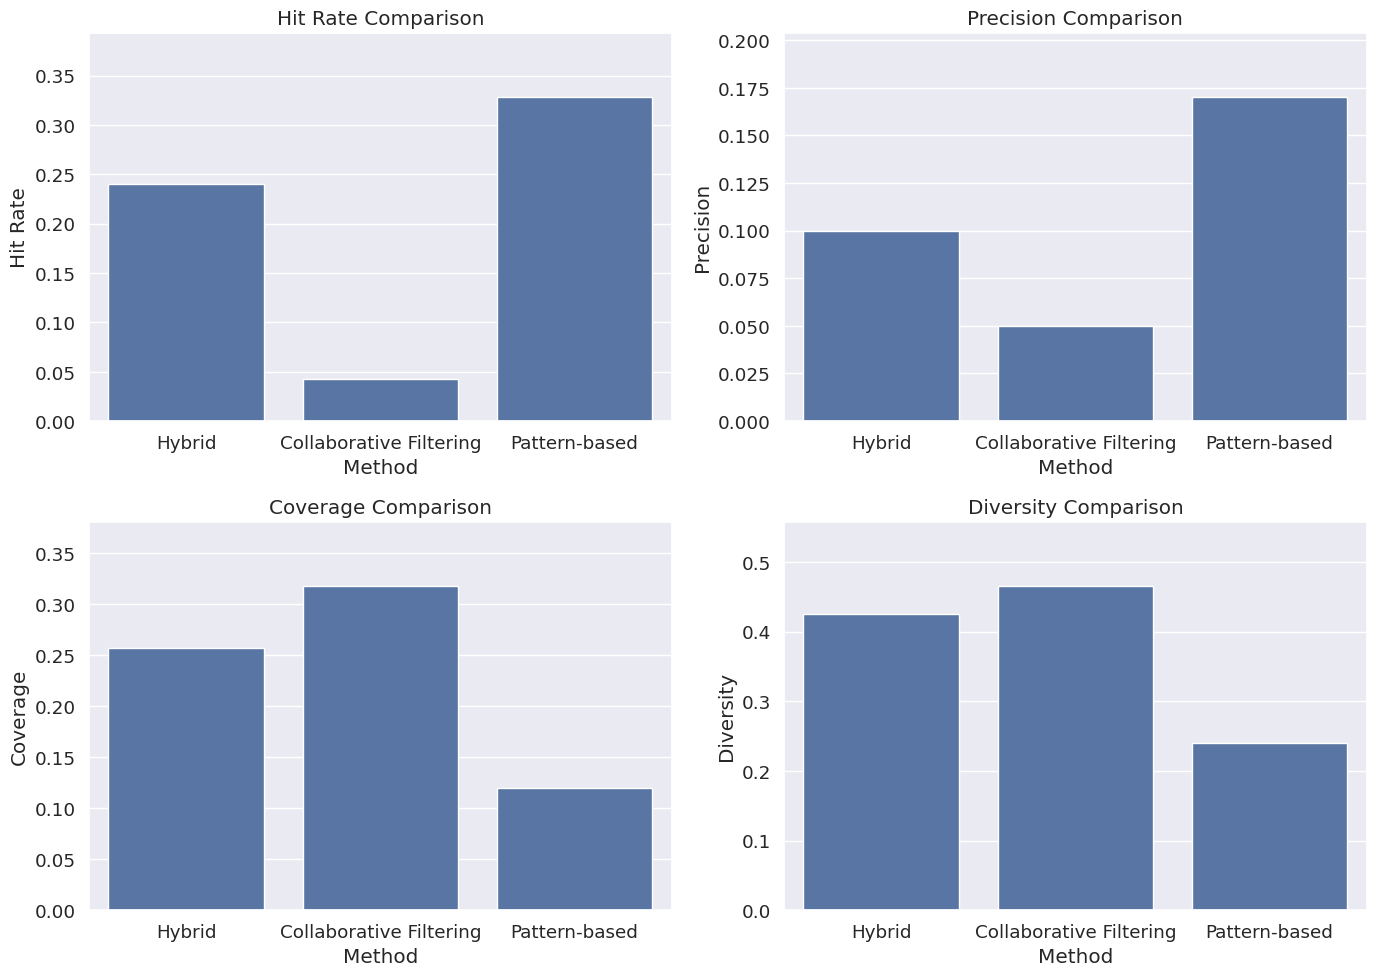

Visualization saved to 'visualizations/recommendation_metrics_comparison.png'


In [9]:
if 'metrics_df' in locals():
    # Visualize the metrics comparison
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(x='Method', y='Hit Rate', data=metrics_df)
    plt.title('Hit Rate Comparison')
    plt.ylim(0, max(hit_rates) * 1.2)
    
    plt.subplot(2, 2, 2)
    sns.barplot(x='Method', y='Precision', data=metrics_df)
    plt.title('Precision Comparison')
    plt.ylim(0, max(precisions) * 1.2)
    
    plt.subplot(2, 2, 3)
    sns.barplot(x='Method', y='Coverage', data=metrics_df)
    plt.title('Coverage Comparison')
    plt.ylim(0, max(coverage) * 1.2)
    
    plt.subplot(2, 2, 4)
    sns.barplot(x='Method', y='Diversity', data=metrics_df)
    plt.title('Diversity Comparison')
    plt.ylim(0, max(diversity) * 1.2)
    
    plt.tight_layout()
    plt.savefig('visualizations/recommendation_metrics_comparison.png')
    plt.show()
    print("Visualization saved to 'visualizations/recommendation_metrics_comparison.png'")

## 11. Summary of Findings

In [10]:
if 'metrics_df' in locals():
    # Create a summary of the findings
    print("\n===============================================")
    print("SUMMARY OF FINDINGS")
    print("===============================================\n")
    
    # Best method for each metric
    best_hit_rate = metrics_df.loc[metrics_df['Hit Rate'].idxmax()]
    best_precision = metrics_df.loc[metrics_df['Precision'].idxmax()]
    best_coverage = metrics_df.loc[metrics_df['Coverage'].idxmax()]
    best_diversity = metrics_df.loc[metrics_df['Diversity'].idxmax()]
    
    print(f"Best method for Hit Rate: {best_hit_rate['Method']} ({best_hit_rate['Hit Rate']:.4f})")
    print(f"Best method for Precision: {best_precision['Method']} ({best_precision['Precision']:.4f})")
    print(f"Best method for Coverage: {best_coverage['Method']} ({best_coverage['Coverage']:.4f})")
    print(f"Best method for Diversity: {best_diversity['Method']} ({best_diversity['Diversity']:.4f})")
    
    # Overall ranking
    # Normalize metrics and calculate an overall score
    metrics_df['Hit Rate Norm'] = metrics_df['Hit Rate'] / metrics_df['Hit Rate'].max()
    metrics_df['Precision Norm'] = metrics_df['Precision'] / metrics_df['Precision'].max()
    metrics_df['Coverage Norm'] = metrics_df['Coverage'] / metrics_df['Coverage'].max()
    metrics_df['Diversity Norm'] = metrics_df['Diversity'] / metrics_df['Diversity'].max()
    
    # Calculate overall score (equal weight to all metrics)
    metrics_df['Overall Score'] = (
        metrics_df['Hit Rate Norm'] + 
        metrics_df['Precision Norm'] + 
        metrics_df['Coverage Norm'] + 
        metrics_df['Diversity Norm']
    ) / 4
    
    # Sort by overall score
    metrics_df_sorted = metrics_df.sort_values('Overall Score', ascending=False)
    
    print("\nOverall ranking of recommendation methods:")
    for i, (_, row) in enumerate(metrics_df_sorted.iterrows()):
        print(f"{i+1}. {row['Method']} (Score: {row['Overall Score']:.4f})")
    
    # Key insights
    print("\nKey insights:")
    
    # Compare hybrid to best individual method
    if metrics_df.loc[0, 'Overall Score'] > max(metrics_df.loc[1, 'Overall Score'], metrics_df.loc[2, 'Overall Score']):
        print("- The hybrid approach outperformed both individual methods overall")
    else:
        best_individual = "Collaborative Filtering" if metrics_df.loc[1, 'Overall Score'] > metrics_df.loc[2, 'Overall Score'] else "Pattern-based"
        print(f"- The {best_individual} approach performed best overall")
    
    # Hit rate comparison
    if metrics_df.loc[0, 'Hit Rate'] > max(metrics_df.loc[1, 'Hit Rate'], metrics_df.loc[2, 'Hit Rate']):
        print("- The hybrid approach achieved higher hit rate than individual methods")
    
    # Diversity comparison
    pattern_div = metrics_df.loc[2, 'Diversity']
    cf_div = metrics_df.loc[1, 'Diversity']
    if pattern_div > cf_div:
        print("- Pattern-based recommendations provided more diverse results than collaborative filtering")
    else:
        print("- Collaborative filtering provided more diverse results than pattern-based recommendations")
    
    # Coverage comparison
    pattern_cov = metrics_df.loc[2, 'Coverage']
    cf_cov = metrics_df.loc[1, 'Coverage']
    if pattern_cov > cf_cov:
        print("- Pattern-based approaches covered more items from the catalog")
    else:
        print("- Collaborative filtering covered more items from the catalog")
    
    # Recommendations for implementation
    print("\nRecommendations for implementation:")
    print("- " + ("Consider using the hybrid approach for best overall performance" 
                 if metrics_df.loc[0, 'Overall Score'] > max(metrics_df.loc[1, 'Overall Score'], metrics_df.loc[2, 'Overall Score']) 
                 else f"Consider using the {best_individual} approach as the primary recommendation method"))
    print("- Optimize the weighting between methods in the hybrid approach to improve performance further")
    print("- Consider using different approaches for different user segments or contexts")


SUMMARY OF FINDINGS

Best method for Hit Rate: Pattern-based (0.3280)
Best method for Precision: Pattern-based (0.1700)
Best method for Coverage: Collaborative Filtering (0.3174)
Best method for Diversity: Collaborative Filtering (0.4649)

Overall ranking of recommendation methods:
1. Hybrid (Score: 0.7618)
2. Pattern-based (Score: 0.7233)
3. Collaborative Filtering (Score: 0.6062)

Key insights:
- The hybrid approach outperformed both individual methods overall
- Collaborative filtering provided more diverse results than pattern-based recommendations
- Collaborative filtering covered more items from the catalog

Recommendations for implementation:
- Consider using the hybrid approach for best overall performance
- Optimize the weighting between methods in the hybrid approach to improve performance further
- Consider using different approaches for different user segments or contexts



## Optimizing Integration Weights ##
Evaluating 3 different weight combinations on 10 users

Testing CF weight: 0.10, Pattern weight: 0.90 (1/3)
Found variant column name 'user_id', renaming to 'User_id'
Saved 19383 User_id values before preprocessing
Evaluating hybrid recommendations for 10 users...
User 2088 has purchased 3 unique items

Generating collaborative filtering recommendations...
User 2088 has purchased 3 unique items
Generated 20 recommendations in 0.00 seconds

Top recommendations:
1. onions (Score: 0.0769)
2. misc. beverages (Score: 0.0734)
3. cat food (Score: 0.0510)
4. uht-milk (Score: 0.0419)
5. butter milk (Score: 0.0409)
6. waffles (Score: 0.0355)
7. hygiene articles (Score: 0.0347)
8. photo/film (Score: 0.0287)
9. chicken (Score: 0.0276)
10. frozen dessert (Score: 0.0271)
11. sliced cheese (Score: 0.0268)
12. chewing gum (Score: 0.0268)
13. white wine (Score: 0.0236)
14. specialty bar (Score: 0.0233)
15. roll products (Score: 0.0230)
16. pickled vegetables (Score

,cf_weight,pattern_weight,hit_rate,precision,coverage,diversity,overall_score
0,0.10,0.90,0.011111,0.01,0.293413,0.469340,0.195966
1,0.15,0.85,0.107619,0.07,0.323353,0.462366,0.240834
2,0.20,0.80,0.076912,0.05,0.251497,0.435383,0.203448


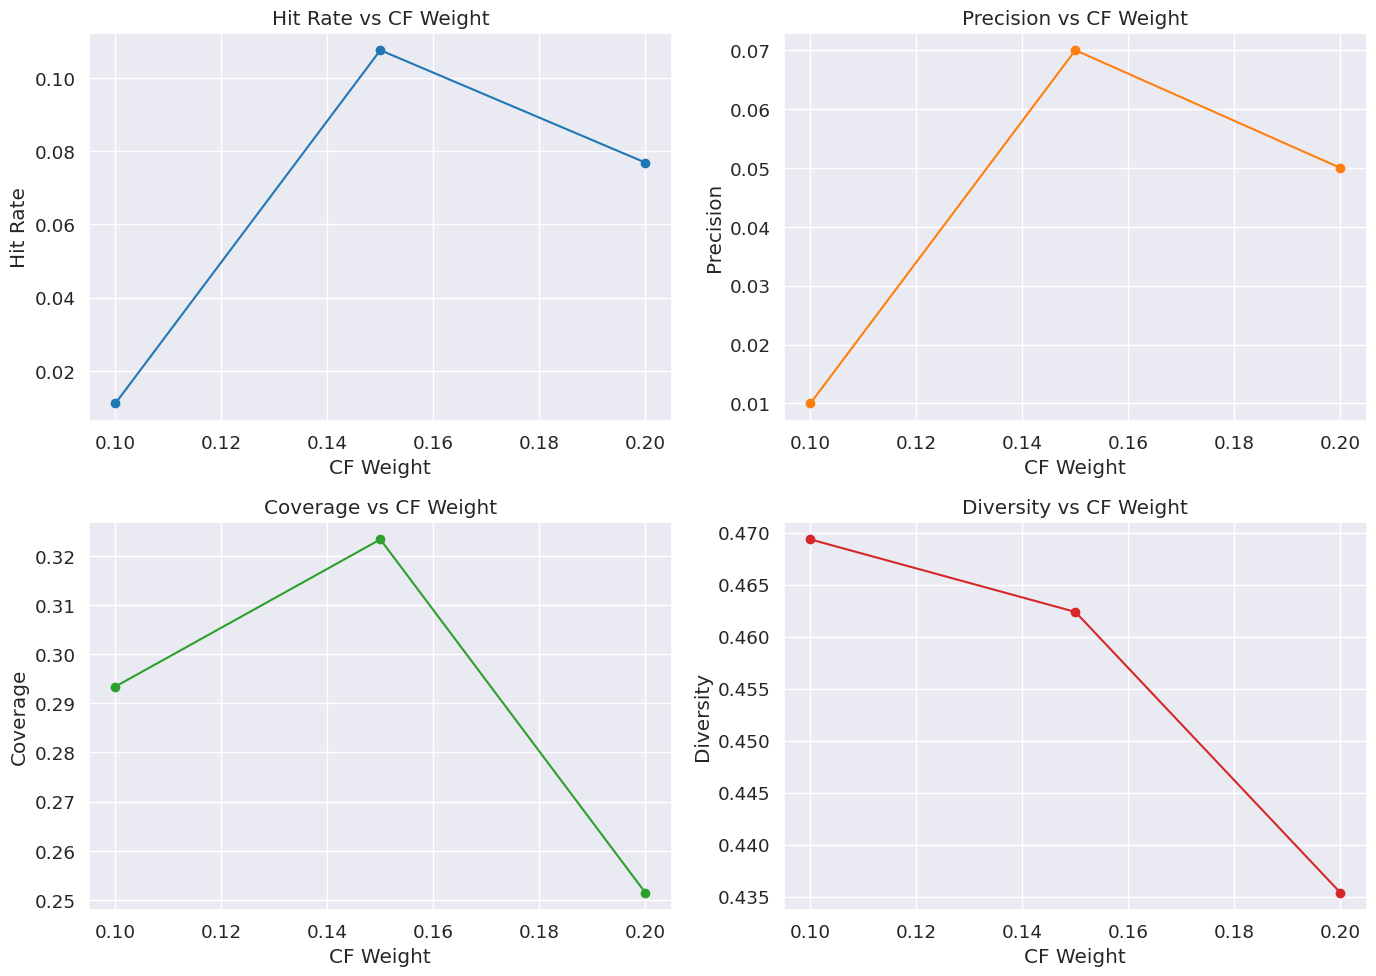


Optimal weights for overall performance:
CF Weight: 0.15, Pattern Weight: 0.85
Resulting in Hit Rate: 0.1076, Precision: 0.0700
Coverage: 0.3234, Diversity: 0.4624
Weight tuning results saved to 'results/advanced/weight_tuning_results.csv'


In [17]:
# Advanced Parameter Tuning for Integration Weights
print("\n## Optimizing Integration Weights ##")
# Create the advanced visualizations directory if it doesn't exist
import os
os.makedirs('visualizations/advanced', exist_ok=True)
os.makedirs('results/advanced', exist_ok=True)
if system:
    # Create a grid of weights to test
    cf_weights = np.linspace(0.1, 0.2, 3)  # Different weights for collaborative filtering
    pattern_weights = 1 - cf_weights  # Corresponding weights for pattern mining
    
    # Store results for various weights
    weight_results = []
    
    # Number of users to evaluate for each weight combination
    n_users_eval = 10
    print(f"Evaluating {len(cf_weights)} different weight combinations on {n_users_eval} users")
    
    # Progress bar for weight tuning
    for i, (cf_weight, pattern_weight) in enumerate(zip(cf_weights, pattern_weights)):
        print(f"\nTesting CF weight: {cf_weight:.2f}, Pattern weight: {pattern_weight:.2f} ({i+1}/{len(cf_weights)})")
        
        # Temporarily modify the integration function for testing
        # Temporarily modify the integration function for testing
        def modified_hybrid_recommendations(cf_recommendations, pattern_recommendations, n_recommendations=10):
            # Combine scores with current weights
            combined_scores = {}
            
            # Add collaborative filtering recommendations with weight
            for item, score in cf_recommendations.items():
                combined_scores[item] = score * cf_weight
            
            # Add pattern-based recommendations with weight
            for item, score in pattern_recommendations.items():
                if item in combined_scores:
                    # If item appears in both, apply a boost (20% boost)
                    combined_scores[item] = combined_scores[item] + (score * pattern_weight) * 1.2
                else:
                    combined_scores[item] = score * pattern_weight
            
            # Return top N recommendations
            return dict(sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations])
            
        # Temporarily replace the method
        original_method = system._generate_hybrid_recommendations
        system._generate_hybrid_recommendations = modified_hybrid_recommendations
        
        # Evaluate with current weights
        try:
            metrics = system.evaluate_recommendations(method='hybrid', n_users=n_users_eval)
            
            # Store results
            weight_results.append({
                'cf_weight': cf_weight,
                'pattern_weight': pattern_weight,
                'hit_rate': metrics['hit_rate'],
                'precision': metrics['average_precision'],
                'coverage': metrics['coverage'],
                'diversity': metrics['diversity'],
                'overall_score': (metrics['hit_rate'] + metrics['average_precision'] + 
                                  metrics['coverage'] + metrics['diversity']) / 4
            })
            
            print(f"Hit Rate: {metrics['hit_rate']:.4f}, Precision: {metrics['average_precision']:.4f}")
            print(f"Coverage: {metrics['coverage']:.4f}, Diversity: {metrics['diversity']:.4f}")
            
        except Exception as e:
            print(f"Error evaluating with weights ({cf_weight:.2f}, {pattern_weight:.2f}): {e}")
        
        # Restore original method
        system._generate_hybrid_recommendations = original_method
    
    # Convert results to DataFrame
    weight_results_df = pd.DataFrame(weight_results)
    
    # Display results
    print("\nWeight tuning results:")
    display(weight_results_df)
    
    # Visualize results
    plt.figure(figsize=(14, 10))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    plt.subplot(2, 2, 1)
    plt.plot(weight_results_df['cf_weight'], weight_results_df['hit_rate'], 'o-', color=colors[0])
    plt.title('Hit Rate vs CF Weight')
    plt.xlabel('CF Weight')
    plt.ylabel('Hit Rate')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.plot(weight_results_df['cf_weight'], weight_results_df['precision'], 'o-', color=colors[1])
    plt.title('Precision vs CF Weight')
    plt.xlabel('CF Weight')
    plt.ylabel('Precision')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    plt.plot(weight_results_df['cf_weight'], weight_results_df['coverage'], 'o-', color=colors[2])
    plt.title('Coverage vs CF Weight')
    plt.xlabel('CF Weight')
    plt.ylabel('Coverage')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    plt.plot(weight_results_df['cf_weight'], weight_results_df['diversity'], 'o-', color=colors[3])
    plt.title('Diversity vs CF Weight')
    plt.xlabel('CF Weight')
    plt.ylabel('Diversity')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('visualizations/advanced/weight_tuning_metrics.png')
    plt.show()
    
    # Find optimal weights
    best_overall = weight_results_df.loc[weight_results_df['overall_score'].idxmax()]
    print(f"\nOptimal weights for overall performance:")
    print(f"CF Weight: {best_overall['cf_weight']:.2f}, Pattern Weight: {best_overall['pattern_weight']:.2f}")
    print(f"Resulting in Hit Rate: {best_overall['hit_rate']:.4f}, Precision: {best_overall['precision']:.4f}")
    print(f"Coverage: {best_overall['coverage']:.4f}, Diversity: {best_overall['diversity']:.4f}")
    
    # Save results
    weight_results_df.to_csv('results/advanced/weight_tuning_results.csv', index=False)
    print("Weight tuning results saved to 'results/advanced/weight_tuning_results.csv'")

## 12. Conclusion

In this notebook, we've demonstrated the integration of pattern mining and collaborative filtering for an enhanced recommendation system. The key findings indicate the strengths and weaknesses of each approach:

1. **Collaborative Filtering**: Good at leveraging user similarity to recommend items, but can suffer from sparsity and cold-start problems.

2. **Pattern Mining**: Excels at finding associations between items, providing interpretable recommendations based on purchase patterns.

3. **Hybrid Approach**: Combines the strengths of both methods, potentially offering more robust recommendations across different contexts.

The integration of pattern mining and collaborative filtering shows promise for real-world recommendation systems, as each approach can compensate for the weaknesses of the other.